In [ ]:
import datasets

#['abstract_algebra', 'all', 'anatomy', 'astronomy', 'auxiliary_train', 'business_ethics', 'clinical_knowledge', 'college_biology', 'college_chemistry', 'college_computer_science', 'college_mathematics', 'college_medicine', 'college_physics', 'computer_security', 'conceptual_physics', 'econometrics', 'electrical_engineering', 'elementary_mathematics', 'formal_logic', 'global_facts', 'high_school_biology', 'high_school_chemistry', 'high_school_computer_science', 'high_school_european_history', 'high_school_geography', 'high_school_government_and_politics', 'high_school_macroeconomics', 'high_school_mathematics', 'high_school_microeconomics', 'high_school_physics', 'high_school_psychology', 'high_school_statistics', 'high_school_us_history', 'high_school_world_history', 'human_aging', 'human_sexuality', 'international_law', 'jurisprudence', 'logical_fallacies', 'machine_learning', 'management', 'marketing', 'medical_genetics', 'miscellaneous', 'moral_disputes', 'moral_scenarios', 'nutrition', 'philosophy', 'prehistory', 'professional_accounting', 'professional_law', 'professional_medicine', 'professional_psychology', 'public_relations', 'security_studies', 'sociology', 'us_foreign_policy', 'virology', 'world_religions']
subject = "all"
dataset = datasets.load_dataset("cais/mmlu",subject)
print(dataset)
exam = dataset['test']
# filter "high_school_*" subjects
exam = exam.filter(lambda example: example['subject'].startswith('high_school_'))
print(f"Number of exam samples in subject 'high_school_*': {len(exam)}")

DatasetDict({
    test: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 14042
    })
    validation: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 1531
    })
    dev: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 285
    })
    auxiliary_train: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 99842
    })
})


In [13]:
for i in range(5):
    print(f"{(i+1)}: {exam[i]['subject']}")
    print("Q:", exam[i]['question'])
    for j, choice in enumerate(exam[i]['choices']):
        print(f" {j}. {choice}")
    print("A:", exam[i]['choices'][exam[i]['answer']])
    print()


1: abstract_algebra
Q: The cyclic subgroup of Z_24 generated by 18 has order
 0. 4
 1. 8
 2. 12
 3. 6
A: 4

2: abstract_algebra
Q: Find the order of the factor group Z_6/<3>.
 0. 2
 1. 3
 2. 6
 3. 12
A: 3

3: abstract_algebra
Q: Statement 1 | A permutation that is a product of m even permutations and n odd permutations is an even permutation if and only if n is even. Statement 2 | Every group is isomorphic to a group of permutations.
 0. True, True
 1. False, False
 2. True, False
 3. False, True
A: True, True

4: abstract_algebra
Q: Find the order of the factor group (Z_4 x Z_12)/(<2> x <2>)
 0. 2
 1. 3
 2. 4
 3. 12
A: 4

5: abstract_algebra
Q: Find the maximum possible order for some element of Z_4 x Z_6.
 0. 4
 1. 6
 2. 12
 3. 24
A: 12



In [65]:
choices = range(4)
sys_msg = """You are an AI performing a multiple choice question answering task. You MUST respond with ONLY a single number, corresponding to the correct answer choice.

Valid response are: 0, 1, 2, 3

The following are multiple choice questions (with answers) about `{}`. Read the question carefully and choose the correct answer, output only the number."
Do not add any other text, explanations, or markdown formatting."""

def create_chat_prompt(sys_msg, question, answers, subject):
    user_prompt = f"{question}\n" + "\n".join([f"{choice}. {answer}" for choice, answer in zip(choices, answers)]) + "\n\nAnswer:"
    return [
        {"role": "system", "content": sys_msg.format(subject)}, 
        {"role": "user", "content": user_prompt}
    ]
def generate_response(model, tokenizer, test_messages):
    # Apply the chat template
    prompt = tokenizer.apply_chat_template(
        test_messages, 
        tokenize=False, 
        add_generation_prompt=True,
        enable_thinking=False
    )
    
    # Tokenize the input
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    # Generate the output
    outputs = model.generate(
        **inputs,
        max_new_tokens=1,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )
    
    # Decode the output, skipping special tokens and the prompt itself
    response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return response.strip()   
 
for i in range(2):
    test_messages = create_chat_prompt(
        sys_msg,
        exam[i]['question'],
        exam[i]['choices'],
        "college mathematics"
    )
    print("Test messages:", test_messages)


Test messages: [{'role': 'system', 'content': 'You are an AI performing a multiple choice question answering task. You MUST respond with ONLY a single number, corresponding to the correct answer choice.\n\nValid response are: 0, 1, 2, 3\n\nThe following are multiple choice questions (with answers) about `college mathematics`. Read the question carefully and choose the correct answer, output only the number."\nDo not add any other text, explanations, or markdown formatting.'}, {'role': 'user', 'content': 'Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over Q.\n0. 0\n1. 4\n2. 2\n3. 6\n\nAnswer:'}]
Test messages: [{'role': 'system', 'content': 'You are an AI performing a multiple choice question answering task. You MUST respond with ONLY a single number, corresponding to the correct answer choice.\n\nValid response are: 0, 1, 2, 3\n\nThe following are multiple choice questions (with answers) about `college mathematics`. Read the question carefully and choose t

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import pandas as pd
import os
from tqdm import tqdm

def run(model_name,exam,num_test_samples=10):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    model.to("cuda" if torch.cuda.is_available() else "cpu")
    exam = exam.shuffle(seed=42)
    exam_results = []

    for i in tqdm(range(num_test_samples)):
        exam_messages = create_chat_prompt(
            sys_msg,
            exam[i]['question'],
            exam[i]['choices'],
            exam[i]['subject']
        )
        response = generate_response(model, tokenizer, exam_messages)
        try:
            answer_number = int(response)
        except ValueError:
            print("Invalid response:", response)
            continue
        exam_results.append({"model": model_name,"subject": exam[i]['subject'], "true": exam[i]['answer'], "predicted": answer_number})
    #save results to csv
    df = pd.DataFrame(exam_results)
    results_path = "./tmp/mmlu_results.csv"
    if os.path.exists(results_path):
        df.to_csv(results_path, mode='a', header=False, index=False)
    else:
        df.to_csv(results_path, index=False)

In [75]:
import os
os.remove("./tmp/mmlu_results.csv") if os.path.exists("./tmp/mmlu_results.csv") else None

In [ ]:
import os

models = ["Qwen/Qwen3-0.6B", "google/gemma-3-1b-it"]
for model_name in models:
    run(model_name,exam,100)

 94%|█████████▍| 235/250 [08:27<00:32,  2.20s/it]

Invalid response: Answer


100%|██████████| 250/250 [12:58<00:00,  3.11s/it]


DATASET OVERVIEW

Shape: 499 rows × 4 columns

Column names: ['model', 'subject', 'true', 'predicted']

First few rows:
             model                 subject  true  predicted
0  Qwen/Qwen3-0.6B         college_physics     0          1
1  Qwen/Qwen3-0.6B                 anatomy     1          2
2  Qwen/Qwen3-0.6B  high_school_statistics     2          2
3  Qwen/Qwen3-0.6B           miscellaneous     2          2
4  Qwen/Qwen3-0.6B              prehistory     0          0

Data types:
model        object
subject      object
true          int64
predicted     int64
dtype: object

Basic statistics:
             true   predicted
count  499.000000  499.000000
mean     1.607214    1.278557
std      1.109483    1.160149
min      0.000000    0.000000
25%      1.000000    0.000000
50%      2.000000    1.000000
75%      3.000000    2.000000
max      3.000000    3.000000

DATA WITH CORRECTNESS FLAG
             model                 subject  true  predicted  correct
0  Qwen/Qwen3-0.6B         

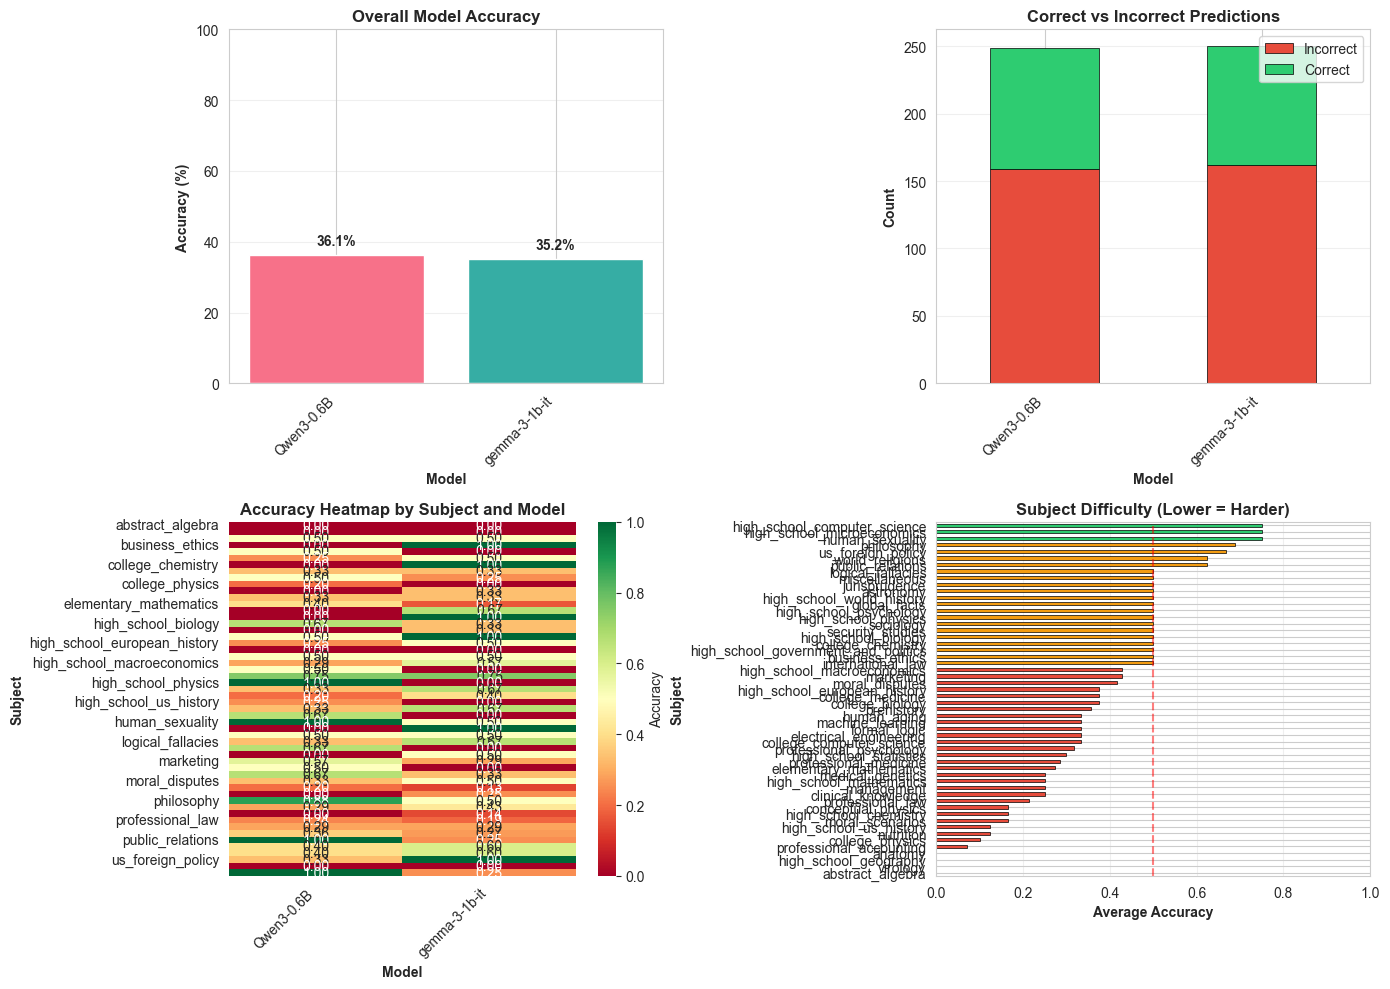

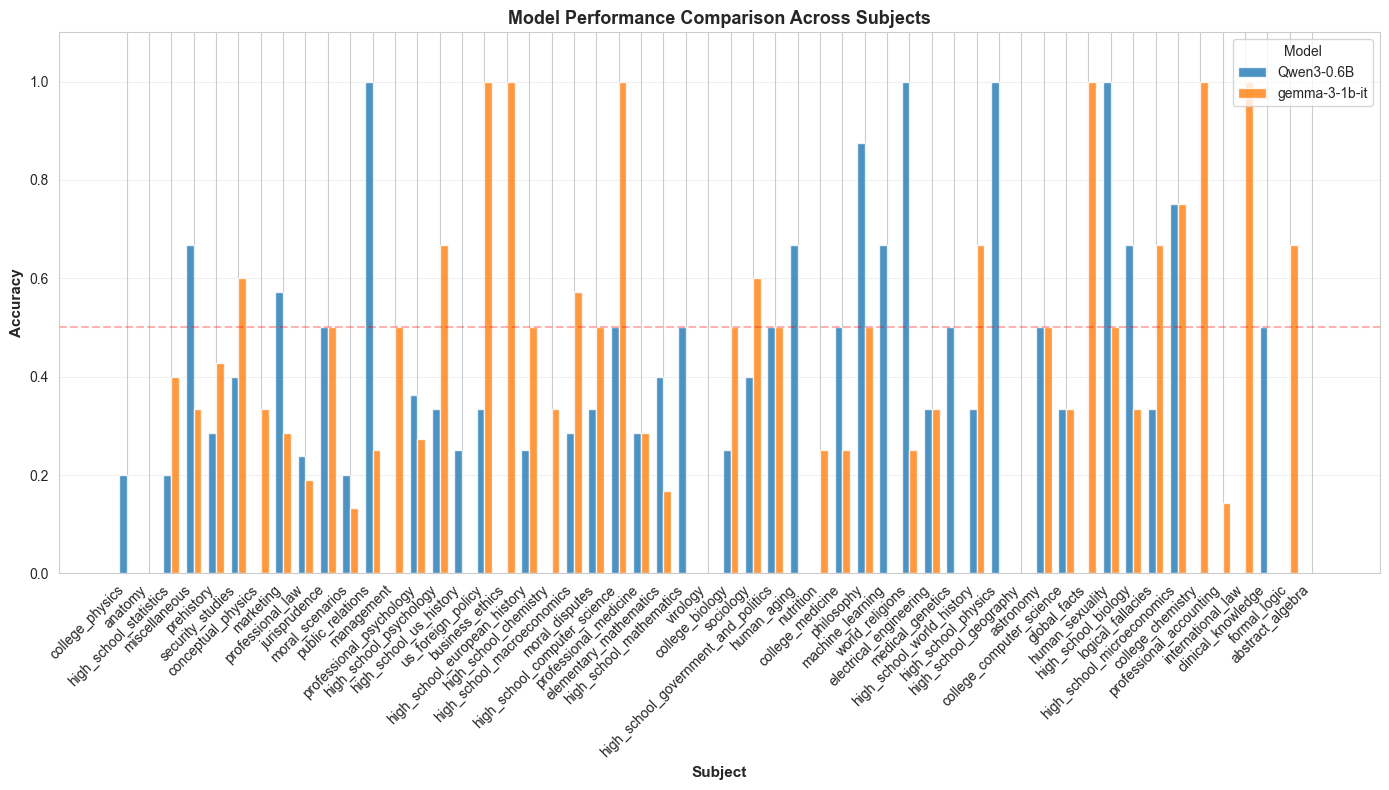


KEY INSIGHTS

1. BEST PERFORMING MODEL:
   → Qwen/Qwen3-0.6B: 36.14% accuracy

2. EASIEST SUBJECT:
   → high_school_microeconomics: 0.75 average accuracy

3. HARDEST SUBJECT:
   → anatomy: 0.00 average accuracy

4. TOTAL PREDICTIONS:
   → 499 total predictions across 2 models
   → 178 correct, 321 incorrect

5. MODEL COMPARISON:
   → Qwen/Qwen3-0.6B: 90/249 correct (36.1%)
   → google/gemma-3-1b-it: 88/250 correct (35.2%)

ANALYSIS COMPLETE!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# ============================================================================
# 1. DATA LOADING AND PREPARATION
# ============================================================================

# Load the data
df = pd.read_csv('./tmp/mmlu_results.csv')

print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"\nShape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumn names: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nBasic statistics:")
print(df.describe())

# Create a binary correctness column
df['correct'] = (df['true'] == df['predicted']).astype(int)

print("\n" + "="*70)
print("DATA WITH CORRECTNESS FLAG")
print("="*70)
print(df.head(10))

# ============================================================================
# 2. MODEL PERFORMANCE METRICS
# ============================================================================

print("\n" + "="*70)
print("OVERALL MODEL PERFORMANCE")
print("="*70)

# Calculate accuracy per model
model_accuracy = df.groupby('model').agg({
    'correct': ['sum', 'count', 'mean']
}).round(4)
model_accuracy.columns = ['Correct', 'Total', 'Accuracy']
model_accuracy['Accuracy_pct'] = (model_accuracy['Accuracy'] * 100).round(2)

print("\n", model_accuracy)

# ============================================================================
# 3. SUBJECT-WISE PERFORMANCE
# ============================================================================

print("\n" + "="*70)
print("PERFORMANCE BY SUBJECT")
print("="*70)

# Performance by subject for each model
subject_performance = df.pivot_table(
    values='correct',
    index='subject',
    columns='model',
    aggfunc='mean'
).round(4)

print("\n", subject_performance)

# Overall accuracy by subject (across all models)
subject_avg = df.groupby('subject')['correct'].agg(['mean', 'sum', 'count']).round(4)
subject_avg.columns = ['Avg_Accuracy', 'Correct_Total', 'Questions']
subject_avg = subject_avg.sort_values('Avg_Accuracy', ascending=False)

print("\nSubjects ranked by average accuracy:")
print(subject_avg)

# ============================================================================
# 4. CONFUSION ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("CONFUSION ANALYSIS (True vs Predicted)")
print("="*70)

for model_name in df['model'].unique():
    model_df = df[df['model'] == model_name]
    print(f"\n{model_name}:")
    confusion = pd.crosstab(
        model_df['true'], 
        model_df['predicted'], 
        rownames=['True'], 
        colnames=['Predicted'],
        margins=True
    )
    print(confusion)

# ============================================================================
# 5. ERROR ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("ERROR ANALYSIS")
print("="*70)

# Get incorrect predictions
errors = df[df['correct'] == 0][['model', 'subject', 'true', 'predicted']]
print(f"\nTotal errors: {len(errors)}")
print("\nError details:")
print(errors)

# Error rate by subject
error_by_subject = df.groupby('subject').agg({
    'correct': lambda x: (1 - x.mean())
}).round(4)
error_by_subject.columns = ['Error_Rate']
error_by_subject = error_by_subject.sort_values('Error_Rate', ascending=False)

print("\nError rates by subject:")
print(error_by_subject)

# ============================================================================
# 6. VISUALIZATIONS
# ============================================================================

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS...")
print("="*70)

# Figure 1: Model Accuracy Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Overall Accuracy Bar Chart
ax1 = axes[0, 0]
models = model_accuracy.index
accuracy_pct = model_accuracy['Accuracy_pct']
colors = sns.color_palette("husl", len(models))
bars = ax1.bar(range(len(models)), accuracy_pct, color=colors)
ax1.set_xlabel('Model', fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontweight='bold')
ax1.set_title('Overall Model Accuracy', fontweight='bold', fontsize=12)
ax1.set_xticks(range(len(models)))
ax1.set_xticklabels([m.split('/')[-1] for m in models], rotation=45, ha='right')
ax1.set_ylim([0, 100])
ax1.grid(axis='y', alpha=0.3)
# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, accuracy_pct)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: Correct vs Incorrect per Model
ax2 = axes[0, 1]
correct_incorrect = df.groupby(['model', 'correct']).size().unstack(fill_value=0)
correct_incorrect.plot(kind='bar', stacked=True, ax=ax2, 
                       color=['#e74c3c', '#2ecc71'], 
                       edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Model', fontweight='bold')
ax2.set_ylabel('Count', fontweight='bold')
ax2.set_title('Correct vs Incorrect Predictions', fontweight='bold', fontsize=12)
ax2.set_xticklabels([m.split('/')[-1] for m in correct_incorrect.index], 
                     rotation=45, ha='right')
ax2.legend(['Incorrect', 'Correct'], loc='upper right')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Heatmap of Performance by Subject
ax3 = axes[1, 0]
heatmap_data = df.pivot_table(
    values='correct',
    index='subject',
    columns='model',
    aggfunc='mean'
)
# Simplify model names for display
heatmap_data.columns = [col.split('/')[-1] for col in heatmap_data.columns]
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', 
            vmin=0, vmax=1, ax=ax3, cbar_kws={'label': 'Accuracy'})
ax3.set_xlabel('Model', fontweight='bold')
ax3.set_ylabel('Subject', fontweight='bold')
ax3.set_title('Accuracy Heatmap by Subject and Model', fontweight='bold', fontsize=12)
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax3.get_yticklabels(), rotation=0)

# Plot 4: Subject Difficulty (Average Accuracy Across Models)
ax4 = axes[1, 1]
subject_difficulty = df.groupby('subject')['correct'].mean().sort_values()
colors_difficulty = ['#e74c3c' if x < 0.5 else '#f39c12' if x < 0.75 else '#2ecc71' 
                     for x in subject_difficulty.values]
subject_difficulty.plot(kind='barh', ax=ax4, color=colors_difficulty, edgecolor='black', linewidth=0.5)
ax4.set_xlabel('Average Accuracy', fontweight='bold')
ax4.set_ylabel('Subject', fontweight='bold')
ax4.set_title('Subject Difficulty (Lower = Harder)', fontweight='bold', fontsize=12)
ax4.set_xlim([0, 1])
ax4.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='50% threshold')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Figure 2: Detailed Subject Comparison
fig, ax = plt.subplots(figsize=(14, 8))

subjects = df['subject'].unique()
x = np.arange(len(subjects))
width = 0.35

# Get data for each model
models_list = df['model'].unique()
model_scores = []
for model in models_list:
    scores = []
    for subject in subjects:
        score = df[(df['model'] == model) & (df['subject'] == subject)]['correct'].mean()
        scores.append(score)
    model_scores.append(scores)

# Create grouped bars
for i, (model, scores) in enumerate(zip(models_list, model_scores)):
    offset = width * (i - len(models_list)/2 + 0.5)
    bars = ax.bar(x + offset, scores, width, label=model.split('/')[-1], alpha=0.8)

ax.set_xlabel('Subject', fontweight='bold', fontsize=11)
ax.set_ylabel('Accuracy', fontweight='bold', fontsize=11)
ax.set_title('Model Performance Comparison Across Subjects', fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(subjects, rotation=45, ha='right')
ax.set_ylim([0, 1.1])
ax.legend(title='Model', loc='upper right')
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.3, label='Random chance')

plt.tight_layout()
plt.show()

# ============================================================================
# 7. KEY INSIGHTS SUMMARY
# ============================================================================

print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

print("\n1. BEST PERFORMING MODEL:")
best_model = model_accuracy['Accuracy_pct'].idxmax()
best_accuracy = model_accuracy['Accuracy_pct'].max()
print(f"   → {best_model}: {best_accuracy:.2f}% accuracy")

print("\n2. EASIEST SUBJECT:")
easiest_subject = subject_avg['Avg_Accuracy'].idxmax()
easiest_acc = subject_avg['Avg_Accuracy'].max()
print(f"   → {easiest_subject}: {easiest_acc:.2f} average accuracy")

print("\n3. HARDEST SUBJECT:")
hardest_subject = subject_avg['Avg_Accuracy'].idxmin()
hardest_acc = subject_avg['Avg_Accuracy'].min()
print(f"   → {hardest_subject}: {hardest_acc:.2f} average accuracy")

print("\n4. TOTAL PREDICTIONS:")
print(f"   → {len(df)} total predictions across {len(df['model'].unique())} models")
print(f"   → {df['correct'].sum()} correct, {len(df) - df['correct'].sum()} incorrect")

print("\n5. MODEL COMPARISON:")
for model in df['model'].unique():
    model_data = df[df['model'] == model]
    correct = model_data['correct'].sum()
    total = len(model_data)
    print(f"   → {model}: {correct}/{total} correct ({correct/total*100:.1f}%)")

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)